# 철광석 주간평균 데이터 분석

In [14]:
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime 
from sklearn.metrics.pairwise import cosine_similarity
krfont = {'family' : 'nanumgothic', 'weight' : 'bold', 'size'   : 10}
matplotlib.rc('font', **krfont)
plt.style.use('ggplot')
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
#matplotlib.rcParams['axes.unicode_minus'] = Falseparse_dates=['date']

## 데이터 로드 및 전처리

### 주간 데이터 읽어오기

In [15]:
df_1 = pd.read_csv('../raw_data_weekly.csv',
                encoding='euc-kr',skiprows=6,parse_dates=['Unnamed: 0'],engine='python')
df_2 = pd.read_csv('data/철광석 주간평균(lag)/철광석 주간평균(lag)2.csv',
                encoding='euc-kr',skiprows=6,parse_dates=['Unnamed: 0'],engine='python')
df_3 = pd.read_csv('data/철광석 주간평균(lag)/철광석 주간평균(lag)3.csv',
                encoding='euc-kr',skiprows=6,parse_dates=['Unnamed: 0'],engine='python')

In [16]:
df1 = pd.merge(df_1,df_2,on=['Unnamed: 0', '철광석 Fines (Daily) [중국(수입가 CFR)] 현물USD/ton'])
df = pd.merge(df1,df_3,on=['Unnamed: 0', '철광석 Fines (Daily) [중국(수입가 CFR)] 현물USD/ton'])

In [17]:
df.head()

,Unnamed: 0,철광석 Fines (Daily) [중국(수입가 CFR)] 현물USD/ton,중국 철광석 생산량10000 tons,주요 중국 철광석 항구재고량mmt,Bloomberg(DJ-UBS) Commodity Index1991=100,Bloomberg Commodity Total Return1991=100,TR/CC CRB Index1967=100,S&P GSCI1970=100,GSCI Energy1970=100,GSCI Petroleum1970=100,...,SSY/Pacific Capesize Index1997.1.6=4114,SSY/Atlantic Capesize Index1997.1.6=5000,Howe Robinson Container Index1997.1.15=1000,China Containerized Freight Index (CCFI)1998.1.1=1000,Shanghai Containerized Freight Index (SCFI)2009.10.16=1000,China Coastal Bulk Freight Index (CBFI)2000.1.1=1000,China Newbuilding Price Index (CNPI)2011.07.01=1000,China Bulker Newbuilding Price Index (CNDPI)2011.07.01=1000,China Tanker Newbuilding Price Index (CNTPI)2011.07.01=1000,China Container Newbuilding Price Index (CNCPI)2011.07.01=1000
0,2018-07-09,63.92,6746.8,153.42,86.13,177.41,198.23,481.11,245.63,269.96,...,6034.0,9953.0,832.0,808.55,817.40,1088.39,801.0,828.0,855.0,821.0
1,2018-07-02,64.05,6746.8,153.42,85.85,176.79,197.31,479.98,244.80,268.86,...,4997.0,8625.0,832.0,808.55,817.40,1088.39,801.0,828.0,855.0,821.0
2,2018-06-25,65.23,6746.8,155.79,86.81,178.70,198.16,477.91,241.55,264.78,...,4977.0,8038.0,842.0,815.89,821.18,1105.50,801.0,828.0,855.0,821.0
3,2018-06-18,66.13,6746.8,154.90,86.95,178.91,195.38,465.20,228.23,249.45,...,5455.0,8331.0,843.0,812.18,751.13,1133.57,794.0,824.0,849.0,810.0
4,2018-06-11,67.37,6746.8,157.23,89.29,183.66,198.97,473.52,231.60,253.27,...,5372.0,7908.0,846.0,814.83,777.70,1150.02,794.0,824.0,849.0,810.0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 0 to 521
Data columns (total 54 columns):
Unnamed: 0                                                           522 non-null datetime64[ns]
철광석 Fines (Daily) [중국(수입가 CFR)] 현물USD/ton                            502 non-null float64
중국 철광석 생산량10000 tons                                                 520 non-null float64
주요 중국 철광석 항구재고량mmt                                                   522 non-null float64
Bloomberg(DJ-UBS) Commodity Index1991=100                            522 non-null float64
Bloomberg Commodity Total Return1991=100                             522 non-null float64
TR/CC CRB Index1967=100                                              522 non-null float64
S&P GSCI1970=100                                                     522 non-null float64
GSCI Energy1970=100                                                  394 non-null float64
GSCI Petroleum1970=100                                               394 non-n

In [19]:
df.columns=['date', 'target',
       '중국 철광석 생산량10000 tons', '주요 중국 철광석 항구재고량mmt',
       'Bloomberg(DJ-UBS) Commodity Index1991=100',
       'Bloomberg Commodity Total Return1991=100', 'TR/CC CRB Index1967=100',
       'S&P GSCI1970=100', 'GSCI Energy1970=100', 'GSCI Petroleum1970=100',
       'GSCI Non-Energy1970=100', 'GSCI Reduced Energy Index (CPW 2)1970=100',
       'GSCI Light Energy Index (CPW 4)1970=100',
       'GSCI Industrial Metals1970=100', 'GSCI Precious Metals1970=100',
       'GSCI Agriculture1970=100', 'GSCI Livestock1970=100',
       'GSCI Softs1970=100', 'Reuters Index of Commodity Prices1931.09.18=100',
       'CRB BLS Spot Index1967=100', 'PDS 원자재 지수2015.01.02=100',
       'PDS 귀금속 하위지수2015.01.02=100', 'PDS 에너지 하위지수2015.01.02=100',
       'PDS 비철금속 하위지수2015.01.02=100', 'PDS 철강 하위지수2015.01.02=100',
       'PDS 석유화학 하위지수2015.01.02=100', 'PDS 농산물 하위지수2015.01.02=100',
       'LMEX Index1999.04=1000', 'US Dollar IndexMar 1973=100',
       'DRAMeXchange Index (DXI)2001.10.01=1000', 'TOCOM Index2002.05.31=100',
       'Rogers International Commodities Index1998.07.31=1000',
       'Rogers International Commodities Index Energy1998.07.31=1000',
       'Rogers International Commodities Index Metals1998.07.31=1000',
       'Rogers International Commodities Index Agriculture1998.07.31=1000',
       'CNY/KRW (중국 인민폐 / 한국 원)', 'USD/RMB (미국 달러 / 중국 인민폐)',
       'Baltic Dry Index (BDI)1985.01.04',
       'Baltic Capesize Index (BCI)1999.03.01',
       'Baltic Panamax Index (BPI)1998.05.06',
       'Baltic Clean Tanker Index (BCTI)1998.08.03',
       'Baltic Dirty Tanker Index (BDTI)1998.08.03',
       'Baltic Supramax index (BSI)2005.01.01',
       'Baltic Handysize Index (BHSI)2006.05.23',
       'SSY/Pacific Capesize Index1997.1.6=4114',
       'SSY/Atlantic Capesize Index1997.1.6=5000',
       'Howe Robinson Container Index1997.1.15=1000',
       'China Containerized Freight Index (CCFI)1998.1.1=1000',
       'Shanghai Containerized Freight Index (SCFI)2009.10.16=1000',
       'China Coastal Bulk Freight Index (CBFI)2000.1.1=1000',
       'China Newbuilding Price Index (CNPI)2011.07.01=1000',
       'China Bulker Newbuilding Price Index (CNDPI)2011.07.01=1000',
       'China Tanker Newbuilding Price Index (CNTPI)2011.07.01=1000',
       'China Container Newbuilding Price Index (CNCPI)2011.07.01=1000']

In [20]:
df.isnull().sum()

## 일단 target에 missing value가 있으면 안되므로 나머지는 나중에 생각하고 target 해당 NA를 drop =====> 20개

date                                                                   0
target                                                                20
중국 철광석 생산량10000 tons                                                   2
주요 중국 철광석 항구재고량mmt                                                     0
Bloomberg(DJ-UBS) Commodity Index1991=100                              0
Bloomberg Commodity Total Return1991=100                               0
TR/CC CRB Index1967=100                                                0
S&P GSCI1970=100                                                       0
GSCI Energy1970=100                                                  128
GSCI Petroleum1970=100                                               128
GSCI Non-Energy1970=100                                              128
GSCI Reduced Energy Index (CPW 2)1970=100                            128
GSCI Light Energy Index (CPW 4)1970=100                              128
GSCI Industrial Metals1970=100                     

In [21]:
df=df.dropna(subset = ['target'])  #target에 NA 가 있으면 해당 행 삭제

In [22]:
df.describe()

,target,중국 철광석 생산량10000 tons,주요 중국 철광석 항구재고량mmt,Bloomberg(DJ-UBS) Commodity Index1991=100,Bloomberg Commodity Total Return1991=100,TR/CC CRB Index1967=100,S&P GSCI1970=100,GSCI Energy1970=100,GSCI Petroleum1970=100,GSCI Non-Energy1970=100,...,SSY/Pacific Capesize Index1997.1.6=4114,SSY/Atlantic Capesize Index1997.1.6=5000,Howe Robinson Container Index1997.1.15=1000,China Containerized Freight Index (CCFI)1998.1.1=1000,Shanghai Containerized Freight Index (SCFI)2009.10.16=1000,China Coastal Bulk Freight Index (CBFI)2000.1.1=1000,China Newbuilding Price Index (CNPI)2011.07.01=1000,China Bulker Newbuilding Price Index (CNDPI)2011.07.01=1000,China Tanker Newbuilding Price Index (CNTPI)2011.07.01=1000,China Container Newbuilding Price Index (CNCPI)2011.07.01=1000
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,394.000000,394.000000,394.000000,...,502.000000,502.000000,502.000000,502.000000,457.000000,502.000000,368.000000,368.000000,368.000000,368.000000
mean,102.087430,10542.773526,95.718247,118.004781,237.690139,252.994124,512.167610,256.237868,279.786320,378.335000,...,5385.692231,6984.024900,542.625100,962.812231,983.727484,1136.650458,865.641304,861.168478,923.627717,872.173913
std,40.600486,2403.751681,25.575515,26.190896,52.100080,54.034152,125.538209,80.401088,89.895263,58.450655,...,2301.232608,2869.695691,140.813654,165.534440,257.985006,229.749929,69.036275,70.443352,61.674499,58.263212
min,38.720000,4723.680000,58.070000,73.800000,148.740000,157.790000,279.490000,103.750000,110.170000,295.880000,...,1594.000000,2419.000000,329.600000,632.360000,400.430000,771.010000,759.000000,747.000000,818.000000,782.000000
25%,64.845000,8841.000000,72.470000,88.402500,178.942500,194.850000,392.770000,175.840000,189.090000,327.775000,...,3953.500000,5185.000000,451.000000,814.275000,797.620000,972.445000,794.000000,793.000000,869.000000,821.000000
50%,92.525000,10922.400000,95.140000,125.255000,252.000000,268.000000,507.400000,282.960000,312.405000,369.900000,...,5023.500000,6303.500000,504.050000,984.720000,1000.000000,1140.270000,869.000000,855.000000,926.500000,872.000000
75%,136.727500,12133.800000,108.170000,137.605000,277.042500,297.262500,638.067500,332.585000,364.497500,427.932500,...,6312.500000,8392.250000,615.750000,1096.922500,1133.000000,1214.465000,928.000000,924.000000,981.000000,901.000000
max,190.540000,18415.800000,162.820000,173.950000,349.640000,367.090000,753.350000,383.480000,420.120000,511.410000,...,15800.000000,19896.000000,916.100000,1335.860000,1583.000000,2115.440000,1000.000000,1000.000000,1003.000000,1011.000000


In [23]:
df.shape

(502, 54)

## 데이터 주요 특성 시각화

### 시간별 철광석 가격

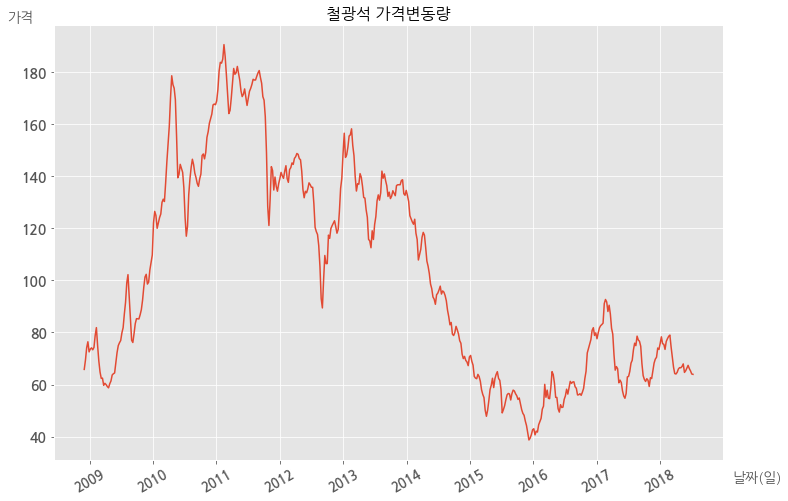

In [24]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plt.xticks(rotation=30, fontsize = 13)
plt.yticks(fontsize = 14)
plt.xlabel('날짜(일)', fontsize=14)
plt.ylabel('가격', fontsize=14, rotation = 0) 
plt.title('철광석 가격변동량', fontsize = 16)

ax.xaxis.set_label_coords(1.05, -0.025)
ax.yaxis.set_label_coords(-0.05, 1.0)

ax.grid(True) # 얇은 선 격자
plt.plot(df['date'],df['target'])
plt.show()

#### 보기 어렵다 연도별 월별 barplot 은 어떨까

연/월/일을 나눠서 column에 추가

In [25]:
df["year"] = df['date'].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
print(df.shape)
df.head()

(502, 57)


,date,target,중국 철광석 생산량10000 tons,주요 중국 철광석 항구재고량mmt,Bloomberg(DJ-UBS) Commodity Index1991=100,Bloomberg Commodity Total Return1991=100,TR/CC CRB Index1967=100,S&P GSCI1970=100,GSCI Energy1970=100,GSCI Petroleum1970=100,...,China Containerized Freight Index (CCFI)1998.1.1=1000,Shanghai Containerized Freight Index (SCFI)2009.10.16=1000,China Coastal Bulk Freight Index (CBFI)2000.1.1=1000,China Newbuilding Price Index (CNPI)2011.07.01=1000,China Bulker Newbuilding Price Index (CNDPI)2011.07.01=1000,China Tanker Newbuilding Price Index (CNTPI)2011.07.01=1000,China Container Newbuilding Price Index (CNCPI)2011.07.01=1000,year,month,day
0,2018-07-09,63.92,6746.8,153.42,86.13,177.41,198.23,481.11,245.63,269.96,...,808.55,817.40,1088.39,801.0,828.0,855.0,821.0,2018,7,9
1,2018-07-02,64.05,6746.8,153.42,85.85,176.79,197.31,479.98,244.80,268.86,...,808.55,817.40,1088.39,801.0,828.0,855.0,821.0,2018,7,2
2,2018-06-25,65.23,6746.8,155.79,86.81,178.70,198.16,477.91,241.55,264.78,...,815.89,821.18,1105.50,801.0,828.0,855.0,821.0,2018,6,25
3,2018-06-18,66.13,6746.8,154.90,86.95,178.91,195.38,465.20,228.23,249.45,...,812.18,751.13,1133.57,794.0,824.0,849.0,810.0,2018,6,18
4,2018-06-11,67.37,6746.8,157.23,89.29,183.66,198.97,473.52,231.60,253.27,...,814.83,777.70,1150.02,794.0,824.0,849.0,810.0,2018,6,11


[Text(0.5,0,'day'), Text(0.5,1,'일별 평균')]

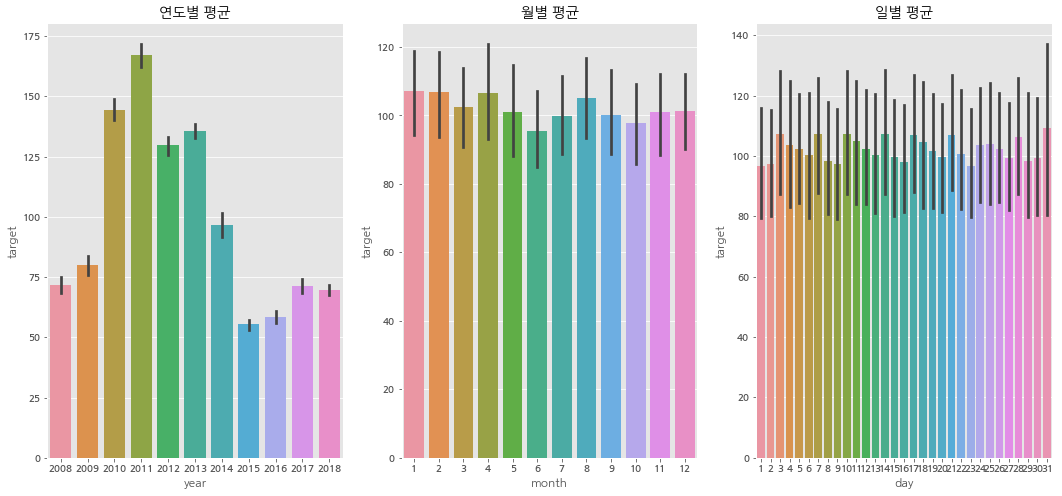

In [26]:
figure, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=df, x="year", y="target", ax=ax1)
sns.barplot(data=df, x="month", y="target", ax=ax2)
sns.barplot(data=df, x="day", y="target", ax=ax3)

ax1.set(ylabel='target',title="연도별 평균")
ax2.set(xlabel='month',title="월별 평균")
ax3.set(xlabel='day', title="일별 평균")

#### 연도별로 2013년이가격이 제일 높았고 17~18년 이 비슷하다 월별 추이를 봤을떄 7~9월 특히 8월 즉 여름시즌이 철광석 가격이 높은걸 알수 있다 6월은 뭔데 가격이 젤 낮을까?? 
(안준) 근데 월별이나 일별이나 다 오차범위 내에 겹쳐있는걸로 봐선 차이가 있다고 할 수는 없을 것 같은데...

### 월별 target plot
행은 month(1~12), 열은 year(2008~2018).

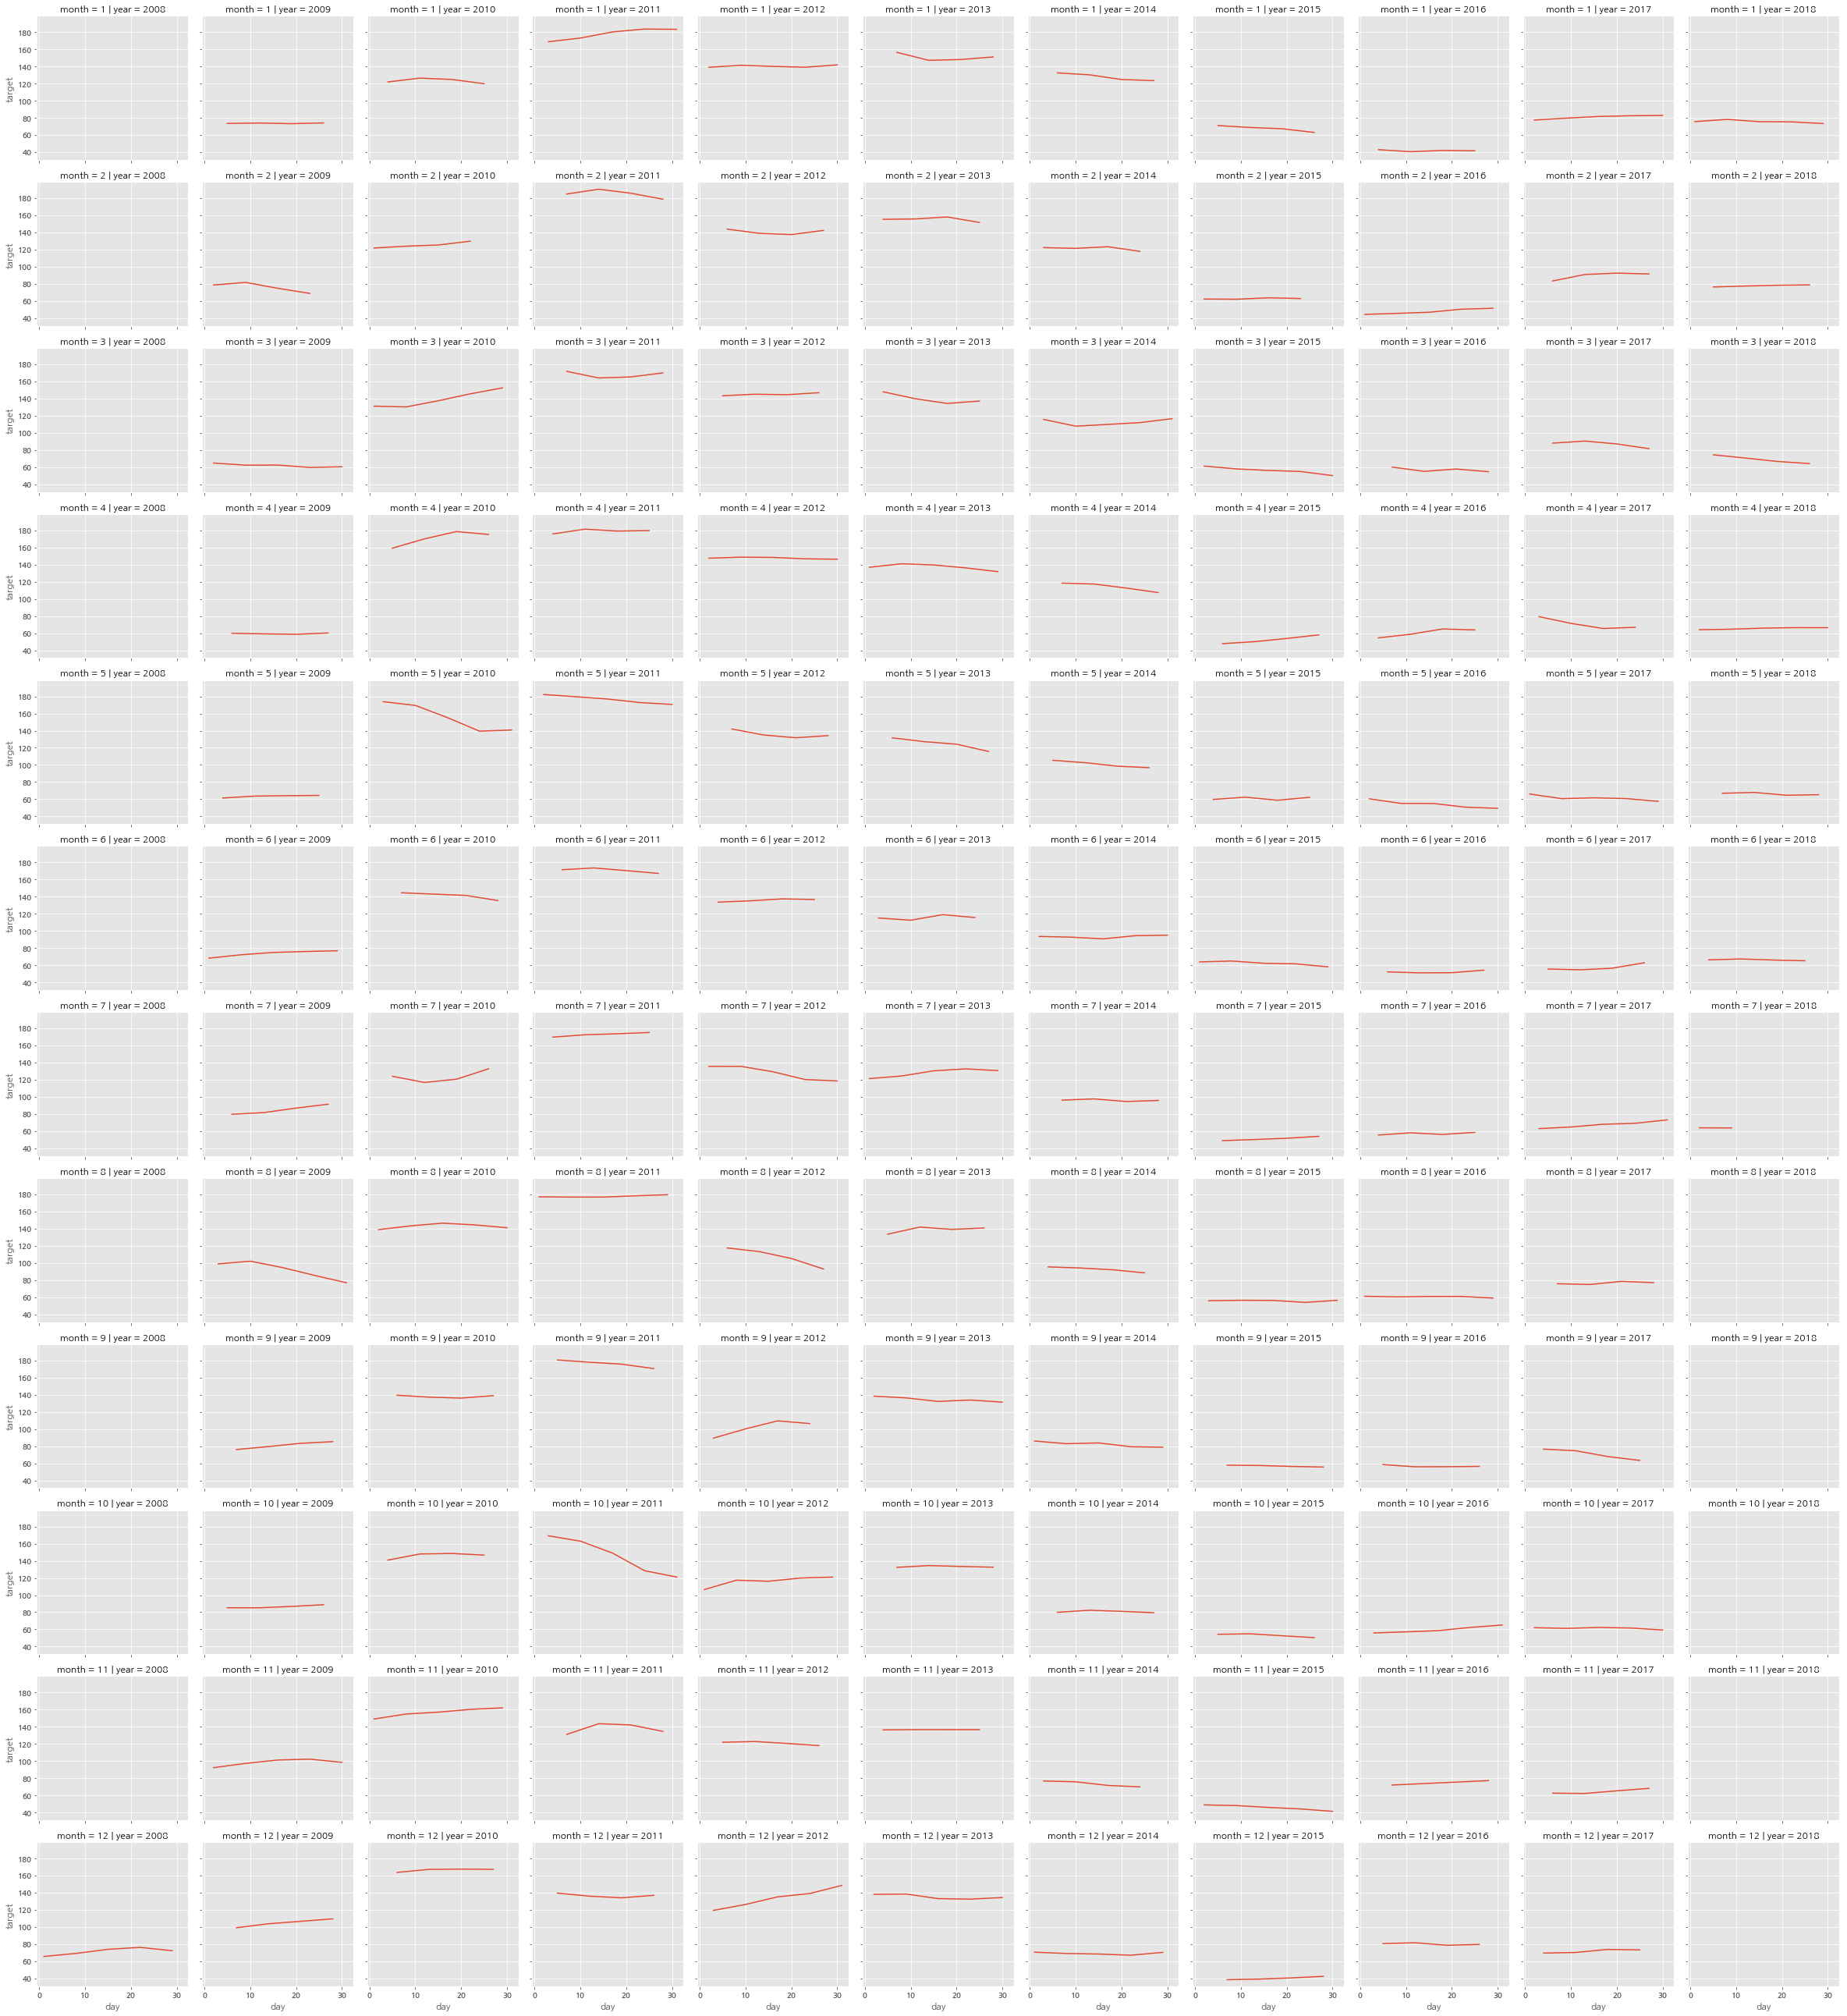

In [27]:
df_sub = df.loc[:,['target','year','month','day']]
#df_sub = df_sub.groupby(by=['year','month']).mean()
#def dateplot(x, y, **kwargs):
#    ax = plt.gca()
#    data = kwargs.pop("data")
#    data.plot(x=x, y=y, ax=ax, grid=False, **kwargs)
ax = sns.FacetGrid(data=df_sub,row='month',col='year')
ax.map(plt.plot,'day','target')

## 시차별 상관관계 구하기
### 상관관계
### 코사인유사도


In [28]:
df.date

0     2018-07-09
1     2018-07-02
2     2018-06-25
3     2018-06-18
4     2018-06-11
5     2018-06-04
6     2018-05-28
7     2018-05-21
8     2018-05-14
9     2018-05-07
10    2018-04-30
11    2018-04-23
12    2018-04-16
13    2018-04-09
14    2018-04-02
15    2018-03-26
16    2018-03-19
17    2018-03-12
18    2018-03-05
19    2018-02-26
20    2018-02-19
21    2018-02-12
22    2018-02-05
23    2018-01-29
24    2018-01-22
25    2018-01-15
26    2018-01-08
27    2018-01-01
28    2017-12-25
29    2017-12-18
         ...    
472   2009-06-22
473   2009-06-15
474   2009-06-08
475   2009-06-01
476   2009-05-25
477   2009-05-18
478   2009-05-11
479   2009-05-04
480   2009-04-27
481   2009-04-20
482   2009-04-13
483   2009-04-06
484   2009-03-30
485   2009-03-23
486   2009-03-16
487   2009-03-09
488   2009-03-02
489   2009-02-23
490   2009-02-16
491   2009-02-09
492   2009-02-02
493   2009-01-26
494   2009-01-19
495   2009-01-12
496   2009-01-05
497   2008-12-29
498   2008-12-22
499   2008-12-

In [29]:
df.date.describe()

count                     502
unique                    502
top       2017-10-30 00:00:00
freq                        1
first     2008-12-01 00:00:00
last      2018-07-09 00:00:00
Name: date, dtype: object

In [30]:
df['target'][:]

0      63.92
1      64.05
2      65.23
3      66.13
4      67.37
5      66.30
6      65.29
7      64.66
8      67.93
9      66.95
10     66.43
11     66.50
12     65.97
13     64.69
14     64.05
15     64.21
16     66.68
17     70.66
18     74.45
19     78.99
20     78.51
21     77.61
22     76.52
23     73.50
24     75.47
25     75.69
26     78.33
27     75.76
28     73.48
29     74.02
       ...  
472    76.05
473    74.94
474    72.24
475    68.31
476    64.45
477    64.15
478    63.67
479    61.38
480    60.31
481    58.73
482    59.23
483    59.96
484    60.48
485    59.70
486    62.47
487    62.37
488    64.81
489    69.04
490    74.98
491    81.86
492    78.83
493    74.25
494    73.34
495    74.09
496    73.64
497    72.54
498    76.43
499    74.15
500    69.38
501    65.82
Name: target, Length: 502, dtype: float64

In [31]:
## 시차별 피어슨 상관관계 함수
def index_corr(df,week):
    index_1=df[df.date<=(df.date.max()- datetime.timedelta(days=(week*7)))]
    index_1 = index_1.drop(["date","target"], axis=1)
    index_1=index_1.reset_index(drop=True)
    
    if week == 0:
        target=df['target'][:]
    else :
        target=df['target'][:-week]
    total=pd.concat([target,index_1],axis=1)
    corr_total=total.corr()
    corr_target=corr_total['target']
    return corr_target

In [77]:
corr_t=[]
tn=[]
for i in range(0,30):
    t = index_corr(df,i)
    corr_t.append(t)
    tn.append('t-'+str(i)+'주')
corr_t = pd.DataFrame(corr_t)
corr_t.index=np.arange(0,30)
corr_t=corr_t.drop('target',1)
corr_t['시점']=tn

In [78]:
cols = corr_t.columns.tolist() 
cols = cols[-1:] + cols[:-1] # 마지막 열을 앞에 열로 보내기
corr_t=corr_t[cols]
corr_t=corr_t.iloc[:,:-3] # year/month/day 제거

In [79]:
corr_t

,시점,중국 철광석 생산량10000 tons,주요 중국 철광석 항구재고량mmt,Bloomberg(DJ-UBS) Commodity Index1991=100,Bloomberg Commodity Total Return1991=100,TR/CC CRB Index1967=100,S&P GSCI1970=100,GSCI Energy1970=100,GSCI Petroleum1970=100,GSCI Non-Energy1970=100,...,SSY/Pacific Capesize Index1997.1.6=4114,SSY/Atlantic Capesize Index1997.1.6=5000,Howe Robinson Container Index1997.1.15=1000,China Containerized Freight Index (CCFI)1998.1.1=1000,Shanghai Containerized Freight Index (SCFI)2009.10.16=1000,China Coastal Bulk Freight Index (CBFI)2000.1.1=1000,China Newbuilding Price Index (CNPI)2011.07.01=1000,China Bulker Newbuilding Price Index (CNDPI)2011.07.01=1000,China Tanker Newbuilding Price Index (CNTPI)2011.07.01=1000,China Container Newbuilding Price Index (CNCPI)2011.07.01=1000
0,t-0주,-0.133718,-0.406748,0.880746,0.882701,0.868078,0.841933,0.860540,0.859338,0.906347,...,0.418065,0.294358,0.242091,0.684236,0.699417,0.639485,0.528165,0.486744,0.288315,0.577547
1,t-1주,-0.141067,-0.412392,0.881856,0.883724,0.866861,0.838805,0.858278,0.857210,0.905900,...,0.421914,0.301381,0.238594,0.679238,0.698472,0.646694,0.519334,0.477459,0.279572,0.570719
2,t-2주,-0.146386,-0.417513,0.881736,0.883503,0.864455,0.834405,0.855776,0.854769,0.905273,...,0.427018,0.309466,0.235315,0.673717,0.696942,0.652656,0.510094,0.467661,0.270411,0.563763
3,t-3주,-0.152845,-0.422103,0.881066,0.882729,0.861695,0.829796,0.853868,0.852820,0.904546,...,0.434349,0.318548,0.232509,0.667961,0.694895,0.655240,0.500733,0.457754,0.261297,0.556682
4,t-4주,-0.160486,-0.426421,0.880289,0.881870,0.858973,0.825284,0.852355,0.851330,0.903569,...,0.442636,0.328646,0.230343,0.662189,0.692003,0.655776,0.490946,0.447416,0.251873,0.549349
5,t-5주,-0.170552,-0.430995,0.879165,0.880658,0.855955,0.820375,0.850600,0.849613,0.901841,...,0.451070,0.338319,0.228788,0.657083,0.688927,0.656585,0.480990,0.436852,0.242530,0.542110
6,t-6주,-0.180414,-0.435259,0.877019,0.878416,0.851741,0.814353,0.847896,0.846966,0.899250,...,0.458847,0.347537,0.227234,0.652057,0.686677,0.658969,0.470535,0.425702,0.232778,0.534507
7,t-7주,-0.191719,-0.440008,0.874368,0.875666,0.846803,0.807604,0.844671,0.843813,0.896906,...,0.466595,0.356371,0.225698,0.647060,0.684732,0.662608,0.460003,0.414238,0.223030,0.526925
8,t-8주,-0.203112,-0.445198,0.871805,0.873014,0.841937,0.800859,0.842365,0.841497,0.895599,...,0.472758,0.364555,0.224044,0.642205,0.682953,0.668237,0.448970,0.402001,0.212707,0.518918
9,t-9주,-0.214477,-0.450520,0.869248,0.870355,0.836962,0.793591,0.839679,0.838838,0.895015,...,0.478026,0.371420,0.222293,0.636929,0.681736,0.675060,0.437578,0.389406,0.202048,0.510580


#### 시점별 선행변수를 추려보자 if T 시점 --  max(all시점) then T 시점은 선행변수

In [80]:
def check_t(corr_t,value):
    qq=[]
    for i in range(0,(len(corr_t.iloc[:,1])-1)):
        if abs(corr_t.iloc[:,value][i]) == abs(max(corr_t.iloc[:,value])):
            qq = ('t-'+str(i)+'주')
    return qq

In [82]:
check=[]
for k in range(1,corr_t.shape[1]):
    a= check_t(corr_t,k)
    if a == []:
        a = ['선행시점없음']
    check.append(a)
pre_corr=pd.DataFrame(check,corr_t.columns[1:],columns=['피어슨선행시점'])#### []공백으로 나오는건 마지막시점이 가장 max 일 경우 즉 쓸데없음
pre_corr

,피어슨선행시점
중국 철광석 생산량10000 tons,t-0주
주요 중국 철광석 항구재고량mmt,t-0주
Bloomberg(DJ-UBS) Commodity Index1991=100,t-1주
Bloomberg Commodity Total Return1991=100,t-1주
TR/CC CRB Index1967=100,t-0주
S&P GSCI1970=100,t-0주
GSCI Energy1970=100,t-0주
GSCI Petroleum1970=100,t-0주
GSCI Non-Energy1970=100,t-0주
GSCI Reduced Energy Index (CPW 2)1970=100,t-0주


#### 이제 시점별 상관관계변화를 한번 시각화해보자

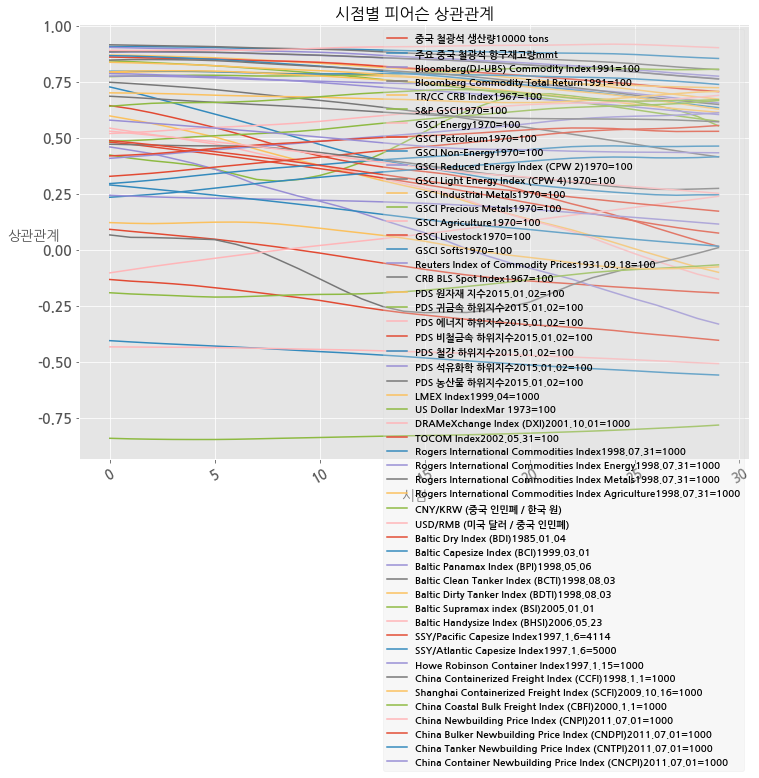

In [98]:
matplotlib.rcParams['axes.unicode_minus'] = False # minus sign 대신 hyphen 사용
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plt.xticks(rotation=30, fontsize = 13)
plt.yticks(fontsize = 14)
plt.xlabel('시점', fontsize=14)
plt.ylabel('상관관계', fontsize=14, rotation = 0) 
plt.title('시점별 피어슨 상관관계', fontsize = 16)


ax.grid(True) # 얇은 선 격자
for i in range(1,corr_t.shape[1]):
    plt.plot(corr_t.iloc[:,i],label=corr_t.columns.values[i])

leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.3)
leg.set_alpha(0.5)
plt.show()

#### 보통 T 시점보다 T-n 시점이 상관관계가 높을경우 선행지표라고 한다

In [100]:
## 상관관계가 +- 0.8 이상인것들
# corr_df 없음.
corr_df[-0.8 > corr_df.target]['target']

AttributeError: 'DataFrame' object has no attribute 'target'

In [ ]:
corr_df[0.8< corr_df.target]['target']

#### 코사인유사도


In [101]:
# 정규화

def normalize(matrix):
    matrix= (matrix-np.mean(matrix))/np.std(matrix)
    return matrix

In [102]:
def cos_sim (n,week):
    index_1=df[df.date<=(df.date.max()- datetime.timedelta(days=(week*7)))]
    index_1 = index_1.drop(["date","target"], axis=1)
    index_1=index_1.reset_index(drop=True)
    
    
    if week == 0:
        target=df['target'][:]
    else :
        target=df['target'][:-week]
    
    total=pd.concat([target,index_1],axis=1)
    total=total.dropna() ## 코사인유사도 이거 NA값들 싹다 제거해도 되나??
    tmp_target = total['target'].values.reshape(1,-1)
    tmp_target = normalize(tmp_target)
    tmp_index = total.iloc[:,n].values.reshape(1,-1)
    tmp_index = normalize(tmp_index)
    cos_t = cosine_similarity(tmp_target,tmp_index)
    return cos_t

In [103]:
def cos_sim_value (n):
    

    cos=[]
    for i in range(0,30):
        cos1 = cos_sim (n,i)[0]
        cos.append(cos1)
    cos = pd.DataFrame(cos)
    return cos

In [104]:
cos_total=cos_sim_value(1)
for j in range(2,56):
    cos2 = cos_sim_value(j)
    cos_total= pd.concat([cos_total,cos2],axis=1)
cos_total.columns=['중국 철광석 생산량10000 tons', '주요 중국 철광석 항구재고량mmt',
       'Bloomberg(DJ-UBS) Commodity Index1991=100',
       'Bloomberg Commodity Total Return1991=100', 'TR/CC CRB Index1967=100',
       'S&P GSCI1970=100', 'GSCI Energy1970=100', 'GSCI Petroleum1970=100',
       'GSCI Non-Energy1970=100', 'GSCI Reduced Energy Index (CPW 2)1970=100',
       'GSCI Light Energy Index (CPW 4)1970=100',
       'GSCI Industrial Metals1970=100', 'GSCI Precious Metals1970=100',
       'GSCI Agriculture1970=100', 'GSCI Livestock1970=100',
       'GSCI Softs1970=100', 'Reuters Index of Commodity Prices1931.09.18=100',
       'CRB BLS Spot Index1967=100', 'PDS 원자재 지수2015.01.02=100',
       'PDS 귀금속 하위지수2015.01.02=100', 'PDS 에너지 하위지수2015.01.02=100',
       'PDS 비철금속 하위지수2015.01.02=100', 'PDS 철강 하위지수2015.01.02=100',
       'PDS 석유화학 하위지수2015.01.02=100', 'PDS 농산물 하위지수2015.01.02=100',
       'LMEX Index1999.04=1000', 'US Dollar IndexMar 1973=100',
       'DRAMeXchange Index (DXI)2001.10.01=1000', 'TOCOM Index2002.05.31=100',
       'Rogers International Commodities Index1998.07.31=1000',
       'Rogers International Commodities Index Energy1998.07.31=1000',
       'Rogers International Commodities Index Metals1998.07.31=1000',
       'Rogers International Commodities Index Agriculture1998.07.31=1000',
       'CNY/KRW (중국 인민폐 / 한국 원)', 'USD/RMB (미국 달러 / 중국 인민폐)',
       'Baltic Dry Index (BDI)1985.01.04',
       'Baltic Capesize Index (BCI)1999.03.01',
       'Baltic Panamax Index (BPI)1998.05.06',
       'Baltic Clean Tanker Index (BCTI)1998.08.03',
       'Baltic Dirty Tanker Index (BDTI)1998.08.03',
       'Baltic Supramax index (BSI)2005.01.01',
       'Baltic Handysize Index (BHSI)2006.05.23',
       'SSY/Pacific Capesize Index1997.1.6=4114',
       'SSY/Atlantic Capesize Index1997.1.6=5000',
       'Howe Robinson Container Index1997.1.15=1000',
       'China Containerized Freight Index (CCFI)1998.1.1=1000',
       'Shanghai Containerized Freight Index (SCFI)2009.10.16=1000',
       'China Coastal Bulk Freight Index (CBFI)2000.1.1=1000',
       'China Newbuilding Price Index (CNPI)2011.07.01=1000',
       'China Bulker Newbuilding Price Index (CNDPI)2011.07.01=1000',
       'China Tanker Newbuilding Price Index (CNTPI)2011.07.01=1000',
       'China Container Newbuilding Price Index (CNCPI)2011.07.01=1000',
       'year', 'month', 'day']

In [105]:
cos_total['시점']=tn
cols = cos_total.columns.tolist() 
cols = cols[-1:] + cols[:-1] # 마지막 열을 앞에 열로 보내기
cos_total=cos_total[cols]
cos_total

,시점,중국 철광석 생산량10000 tons,주요 중국 철광석 항구재고량mmt,Bloomberg(DJ-UBS) Commodity Index1991=100,Bloomberg Commodity Total Return1991=100,TR/CC CRB Index1967=100,S&P GSCI1970=100,GSCI Energy1970=100,GSCI Petroleum1970=100,GSCI Non-Energy1970=100,...,China Containerized Freight Index (CCFI)1998.1.1=1000,Shanghai Containerized Freight Index (SCFI)2009.10.16=1000,China Coastal Bulk Freight Index (CBFI)2000.1.1=1000,China Newbuilding Price Index (CNPI)2011.07.01=1000,China Bulker Newbuilding Price Index (CNDPI)2011.07.01=1000,China Tanker Newbuilding Price Index (CNTPI)2011.07.01=1000,China Container Newbuilding Price Index (CNCPI)2011.07.01=1000,year,month,day
0,t-0주,-0.051196,0.552844,0.135899,0.171022,0.118790,0.487035,0.475849,0.458970,0.465100,...,0.208543,0.533711,0.576181,-0.515971,-0.417142,-0.597642,-0.597001,0.543603,-0.181878,-0.009997
1,t-1주,-0.007377,0.555141,0.103088,0.137576,0.084177,0.466418,0.458419,0.441723,0.435877,...,0.190864,0.529974,0.591416,-0.534723,-0.440164,-0.609511,-0.611776,0.549042,-0.163607,0.002223
2,t-2주,0.036021,0.558005,0.070509,0.104383,0.049761,0.445410,0.440538,0.423686,0.407505,...,0.169917,0.526277,0.604150,-0.553947,-0.463993,-0.621969,-0.626144,0.555201,-0.144926,0.011902
3,t-3주,0.060103,0.559153,0.041777,0.074976,0.020323,0.425713,0.424055,0.406563,0.378413,...,0.147173,0.526711,0.607675,-0.568245,-0.481515,-0.630589,-0.637383,0.559056,-0.125284,0.024482
4,t-4주,0.072693,0.558441,0.013882,0.046381,-0.008659,0.402577,0.403183,0.384549,0.348337,...,0.122101,0.522616,0.604813,-0.580828,-0.497095,-0.637640,-0.647432,0.563160,-0.111286,0.042280
5,t-5주,0.065591,0.557026,-0.009523,0.022171,-0.031249,0.382130,0.384740,0.364906,0.321047,...,0.101414,0.513663,0.594396,-0.587694,-0.507046,-0.640386,-0.652871,0.562186,-0.090200,0.035942
6,t-6주,0.058442,0.555201,-0.039095,-0.008292,-0.059799,0.356741,0.362660,0.341769,0.282271,...,0.080091,0.497366,0.583168,-0.594112,-0.516578,-0.642847,-0.657447,0.558426,-0.061932,0.042152
7,t-7주,0.044687,0.550957,-0.072187,-0.042362,-0.093117,0.327245,0.336229,0.314240,0.241301,...,0.058413,0.478505,0.572980,-0.599404,-0.525273,-0.644211,-0.661195,0.548868,-0.012030,0.025015
8,t-8주,0.035131,0.545567,-0.108648,-0.079802,-0.130197,0.296324,0.309506,0.286511,0.194268,...,0.030649,0.458876,0.565497,-0.607377,-0.537897,-0.646895,-0.666531,0.538525,0.044538,0.015094
9,t-9주,0.035805,0.538037,-0.140286,-0.112438,-0.161740,0.268203,0.285857,0.262428,0.149669,...,-0.000978,0.440134,0.559132,-0.614308,-0.549205,-0.648930,-0.670868,0.527714,0.099781,0.006754


In [ ]:
check_cos=[]
for k in range(1,56):
    a= check_t(cos_total,k)
    if a == []:
        a = ['선행시점없음']
    check_cos.append(a)
pre_cos=pd.DataFrame(check,cos_total.columns[1:],columns=['코사인선행시점'])#### []공백으로 나오는건 마지막시점이 가장 max 일 경우 즉 쓸데없음
pd.concat([pre_corr,pre_cos],axis=1)

# 시발 그냥 코사인유사도나 피어슨상관계수나 선행시점 결과는 똑같았다 시간아깝네

In [ ]:
a=cos_total.describe()
a.ix['max'][a.ix['max']>0.6]

In [ ]:
b=corr_t.describe()
b.ix['max'][b.ix['max']>0.7]

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

plt.xticks(rotation=30, fontsize = 13)
plt.yticks(fontsize = 14)
plt.xlabel('시점', fontsize=14)
plt.ylabel('유사도', fontsize=14, rotation = 0) 
plt.title('시점별 코사인 유사도', fontsize = 16)

ax.grid(True) # 얇은 선 격자
plt.plot(cos_total.iloc[:,1:])
plt.show()